In [1]:
import re
from pandas import Series, DataFrame
import pandas as pd
import nltk
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import statsmodels.api as sm
from patsy import dmatrices
from scipy import stats
%pylab inline

C:\Users\Abraham\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


In [2]:
#Read files
df_raw = pd.read_csv(r'C:\Users\Abraham\MSBA\Text\HW1\Train_rev1.csv')
df_train = df_raw.sample(2500)

# Part A1

Randomly select 2500 data points (the training dataset train_rev1 contains nearly 250k) for ease of analysis. 
(A1) What are the top 5 parts of speech in the job descriptions? How frequently do they appear? How do these numbers change if you exclude stopwords?

In [3]:
df_train = df_train[['Id','FullDescription','SalaryNormalized']]
df_train['FullDescription'] = df_train['FullDescription'].map(str.lower)

In [4]:
#Tag all parts of speech
pos_dt = {}

#Function to split a job description into words and tag POS
def pos_count(desc):
    tokens = re.findall('\w+', desc)
    tokenlist = nltk.pos_tag(tokens)
    
    for t in tokenlist:
        pos = t[1]
        if pos in pos_dt:
            pos_dt[pos] += 1
        else:
            pos_dt[pos] = 1
    
    return desc

#Map function
df_train['FullDescription'].map(pos_count)

pos_dt

{'$': 23,
 "''": 2,
 'CC': 30973,
 'CD': 4702,
 'DT': 49595,
 'EX': 226,
 'FW': 408,
 'IN': 63791,
 'JJ': 69298,
 'JJR': 881,
 'JJS': 1174,
 'MD': 9841,
 'NN': 159256,
 'NNP': 238,
 'NNS': 51266,
 'PDT': 142,
 'POS': 7,
 'PRP': 12275,
 'PRP$': 7713,
 'RB': 14978,
 'RBR': 255,
 'RBS': 266,
 'RP': 967,
 'TO': 19931,
 'UH': 5,
 'VB': 32003,
 'VBD': 3416,
 'VBG': 22708,
 'VBN': 11962,
 'VBP': 15502,
 'VBZ': 10657,
 'WDT': 1314,
 'WP': 1372,
 'WP$': 21,
 'WRB': 874}

In [5]:
#Same as above, but stop words were removed
stop_words = set(stopwords.words('english'))

pos_nostop_dt = {}

def pos_nostop_count(desc):
    tokens = re.findall('\w+', desc)
    filtered_tokens = [w for w in tokens if not w in stop_words]
    
    tokenlist = nltk.pos_tag(filtered_tokens)
    
    for t in tokenlist:
        pos = t[1]
        if pos in pos_nostop_dt:
            pos_nostop_dt[pos] += 1
        else:
            pos_nostop_dt[pos] = 1
    
    return desc

df_train['FullDescription'].map(pos_nostop_count)

pos_nostop_dt

{'$': 14,
 "''": 1,
 'CC': 494,
 'CD': 4727,
 'DT': 289,
 'EX': 2,
 'FW': 508,
 'IN': 5958,
 'JJ': 71938,
 'JJR': 356,
 'JJS': 1128,
 'MD': 2494,
 'NN': 153202,
 'NNP': 315,
 'NNS': 50780,
 'POS': 2,
 'PRP': 582,
 'PRP$': 5,
 'RB': 13235,
 'RBR': 239,
 'RBS': 44,
 'RP': 68,
 'SYM': 3,
 'UH': 4,
 'VB': 7412,
 'VBD': 8006,
 'VBG': 25683,
 'VBN': 7327,
 'VBP': 17173,
 'VBZ': 3894,
 'WDT': 15,
 'WP': 30,
 'WP$': 21,
 'WRB': 30}

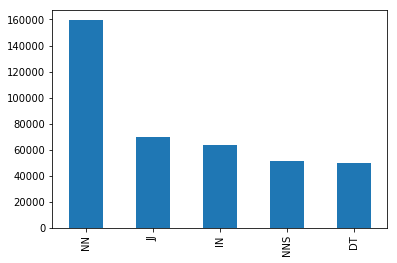

In [6]:
#Top 5 POS still including stop words
Series(pos_dt).sort_values(ascending=False)[0:5].plot(kind='bar')

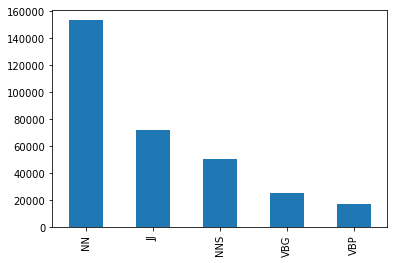

In [7]:
#Top 5 POS after removing stop words
Series(pos_nostop_dt).sort_values(ascending=False)[0:5].plot(kind='bar')

Nouns make up almost 160k words of the roughly 400k in the 2500 job descriptions. Adjectives make up around 70k words, but the next 3 top categories depend on if we include stop words. Prepositions (IN) and Determiners (DT) disappear from the top 5 after removing stop words and verbs move up the ranking.

# Part A2

Does this data support Zipf’s law? Plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization.

In [8]:
#Concatenate all descriptions into one string and split into words
a = df_train['FullDescription'].str.cat(sep = ' ')
s = re.findall('\w+', a)
s = Series(s)

#Get word counts
df_words = DataFrame(s.value_counts())
df_words = df_words.reset_index()
df_words.columns = ['Word','Counts']

In [11]:
#Rank words by count, take log of rank and log of count
df_words['Rank'] = df_words['Counts'].rank(ascending=False)
constant = df_words.iloc[-1]['Counts']*df_words.iloc[-1]['Rank']
df_words['LogCount'] = log(df_words['Counts']/constant)
df_words['LogRank'] = log(df_words['Rank'])

#Run and plot linear regression on the log-log relationship
Y, X = dmatrices('LogRank~LogCount', data=df_words, return_type='dataframe')
model = sm.OLS(Y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                LogRank   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 8.957e+05
Date:                Wed, 12 Sep 2018   Prob (F-statistic):               0.00
Time:                        11:34:12   Log-Likelihood:                 9834.7
No. Observations:               17526   AIC:                        -1.967e+04
Df Residuals:                   17524   BIC:                        -1.965e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5767      0.006    639.468      0.0

After linear regression, the log(count/min count) has a coefficient of -0.6 with respect to log(rank) so our dataset only loosely follows Zipf's law. A large number of words with low frequencies "flatten" the curve because the change from word to the next does not exactly follow the inverse-rank stated by Zipf's law.

In [15]:
#Same regression but using only the top 100 words
Y, X = dmatrices('LogRank~LogCount', data=df_words[0:1000], return_type='dataframe')
model = sm.OLS(Y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                LogRank   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 2.333e+05
Date:                Wed, 12 Sep 2018   Prob (F-statistic):               0.00
Time:                        11:35:38   Log-Likelihood:                 1325.5
No. Observations:                1000   AIC:                            -2647.
Df Residuals:                     998   BIC:                            -2637.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5380      0.009    165.699      0.0

Looking at only the 1000 most frequent words results in a rank-count relationship that follows Zipf's law much closer with a coefficient of almost exactly -1

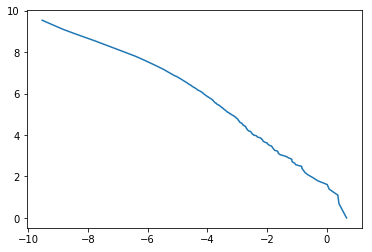

In [26]:
plot(df_words['LogCount'],df_words['LogRank'], linestyle='-')


# Part A3

If we remove stopwords and lemmatize the data, what are the 10 most common words? What are their frequencies?

In [16]:
s = re.findall('\w+', a)
s = [w for w in s if not w in stop_words]

lemmatizer = WordNetLemmatizer()
s = Series(s).map(lemmatizer.lemmatize)

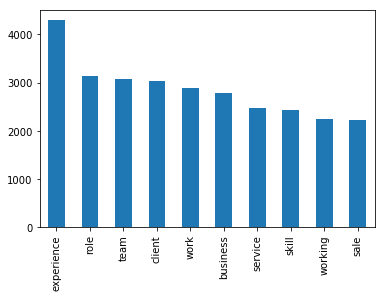

In [17]:
s.value_counts()[0:10].plot(kind='bar')

Experience is the most common word by far, showing up more than 4,000 times in 2,500 job descriptions

# Part B1

Ignore the job descriptions, and train a model to predict high/low salary from all the numeric columns, e.g., part time/full time, contract vs. others, type of job (a lot of dummy variables), location (instead of using a huge number of dummy variables, you can use a list of cities in England with highest cost of living, and create a 0/1 variable which is 1 if the job is in one of those cities, else 0). Use the Naïve Bayes classifier. What is the accuracy of your model?    

In [37]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

In [28]:
df_train = df_raw.dropna().sample(2500)
cutoff = df_train['SalaryNormalized'].quantile(0.75)

df_train['HighSalary'] = 0
df_train['HighSalary'][df_train['SalaryNormalized']>cutoff] = 1

df_train.head()

C:\Users\Abraham\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,HighSalary
41037,68371413,Teaching Assistant,Graduate Teaching Assistant required for a Pri...,Greater Manchester,Manchester,full_time,contract,EDUSTAFF,Teaching Jobs,Up to 300 per week with tax effeciency scheme,14400,jobs.guardian.co.uk,0
157655,71113341,Front Line Manager,KEY ACCOUNTABILITIES RESPONSIBILITIES Actively...,Lancashire - Preston,Preston,full_time,permanent,UKStaffsearch,Engineering Jobs,40000 - 49999,44999,ukstaffsearch.com,1
240317,72637120,Cluster Manager (Libraries),Job Reference: LBC**** Job Title: Cluster Mana...,West London,West London,full_time,permanent,LONDON BOROUGH OF CAMDEN,Other/General Jobs,"33,436 + 25 days leave (27 after 5 year's serv...",33436,jobs.guardian.co.uk,0
208655,72158746,PPA Cover Primary Teachers in Barnet,PPA Cover Primary Teachers in Barnet Long term...,London,London,full_time,contract,Tradewind Recruitment,Teaching Jobs,From 120 to 145 per day,31800,JustLondonJobs,0
141102,70583242,Full Time Temporary Lecturer in Motor Vehicle,"As one of the largest colleges in the UK, Belf...",Belfast,Belfast,full_time,contract,Belfast Metropolitan College,Teaching Jobs,"20,000 - 30,000",25000,nijobfinder.co.uk,0


In [29]:
df_nbtrain = pd.get_dummies(df_train[['ContractType','ContractTime','Category']])

#Cities where avg rent is >= 20% of avg income
high_cities = ['London', 'Central London','The City','Brighton','Edinburgh','Bristol','Southampton','Portsmouth','Exeter'\
                 ,'Cardiff', 'Manchester', 'Birmingham', 'Leeds', 'Aberdeen', 'Glasgow', 'Newcastle', 'Sheffield', 'Liverpool', 'Hull']

a = df_train['LocationNormalized']
b = []

#Create dummy variable for expensive cities
for i in range(len(a)):
    if a.iloc[i] in high_cities: 
        b.append(1)
    else: b.append(0)


df_nbtrain['ExpensiveCity'] = b
df_nbtrain['HighSalary'] = df_train['HighSalary']

#Drop extra dummies
df_nbtrain = df_nbtrain.drop(['ContractType_part_time','ContractTime_contract','Category_Travel Jobs'], axis=1)
df_nbtrain.head()


,ContractType_full_time,ContractTime_permanent,Category_Accounting & Finance Jobs,Category_Admin Jobs,Category_Charity & Voluntary Jobs,Category_Consultancy Jobs,Category_Creative & Design Jobs,Category_Customer Services Jobs,Category_Domestic help & Cleaning Jobs,"Category_Energy, Oil & Gas Jobs",...,"Category_PR, Advertising & Marketing Jobs",Category_Property Jobs,Category_Retail Jobs,Category_Sales Jobs,Category_Scientific & QA Jobs,Category_Social work Jobs,Category_Teaching Jobs,Category_Trade & Construction Jobs,ExpensiveCity,HighSalary
41037,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
157655,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
240317,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
208655,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
141102,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [30]:
from sklearn import naive_bayes
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from sklearn import metrics

In [82]:
dummy_column_names = list(df_nbtrain.columns.values)[:-1]

formula = 'HighSalary ~ 0 + {}'.format(' + '.join(['Q("{}")'.format(x) for x in dummy_column_names]))

nbtrain, nbtest = train_test_split(df_nbtrain, test_size=0.2)
    
#Training Sets
Ytrain, xtrain = dmatrices(formula, nbtrain, return_type='dataframe')
ytrain = Ytrain['HighSalary'].values

#Testing Set
Ytest, xtest = dmatrices(formula, nbtest, return_type='dataframe')
ytest = Ytest['HighSalary'].values

model = naive_bayes.MultinomialNB()
model.fit(xtrain, ytrain)

prediction_train = model.predict(xtrain)
print ("Training Accuracy")
print (metrics.accuracy_score(ytrain, prediction_train))

print (" ")
print ("Test Accuracy")
prediction_test = model.predict(xtest)
print (metrics.accuracy_score(ytest, prediction_test))

#Baseline accuracy = if we guessed 'No' for all of them
print (" ")
print ("Baseline Accuracy")
print (1-ytest.mean())

#Row 1 is all the ones low salary
#Column 1 is all the ones predicted low salary
print(' ')
print (metrics.confusion_matrix(ytest, prediction_test))

Training Accuracy
0.754
 
Test Accuracy
0.746
 
Baseline Accuracy
0.75
 
[[371   4]
 [123   2]]


A Binomial Naive Bayes model using every variable except the job description essentially predicts a "Low Salary" for every job and underperforms even the baseline accuracy.

# Part B2 

Create a classification model with all words and the bag-of-words approach. How accurate is the model (show the confusion matrix)? 

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from operator import itemgetter
from sklearn.metrics import classification_report
import csv
import os

In [39]:
df_text = df_train[['FullDescription','HighSalary']]
df_text['FullDescription'] = df_text['FullDescription'].dropna().str.lower().str.replace('\d+', '')\
.map(lambda x:re.findall('\w+',x)).map(lambda x:' '.join([i for i in x if i not in stop_words \
                                                          and i not in string.punctuation]))

C:\Users\Abraham\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
#Split Train and Test sets
#Split descriptions from salary range
X_train, X_test, y_train, y_test = train_test_split(df_text['FullDescription'],
                                                    df_text['HighSalary'],
                                                    test_size=0.3, random_state=1)

In [41]:
#Like the document term matrix, but filled with 1's and 0's instead of TFIDF scores
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

#Fit model on train data
clf = BernoulliNB().fit(X_train_counts, y_train)

#Predict using X_test data
prediction = clf.predict(X_test_counts)

In [48]:
#Percent correct overall
print ('Prediction Accuracy')
print (metrics.accuracy_score(y_test, prediction))
print('  ')
#Baseline accuracy = if we guessed 'No' for all of them
print ('Baseline Accuracy')
print (1-y_test.mean())

Prediction Accuracy
0.794666666667
  
Baseline Accuracy
0.7546666666666667


In [45]:
#Row 1 is all the ones low salary
#Column 1 is all the ones predicted low salary
metrics.confusion_matrix(y_test, prediction)

array([[521,  45],
       [109,  75]])

Accuracy is high on the Low salary jobs, but below 50% on the high salary jobs.

### Also show the top 10 words (excluding stopwords) that are most indicative of (i) high salary, and (ii) low salary.  

In [72]:
df_high = df_text[df_text['HighSalary']==1]

#Concatenate all descriptions into one string and split into words
a = df_high['FullDescription'].str.cat(sep = ' ')
s = re.findall('\w+', a)
s = Series(s)

#Get word counts
high_words = DataFrame(s.value_counts())
high_words.columns=['Count']
high_words['Freq']= high_words['Count']/high_words['Count'].sum()*100
high_words[0:10]

,Count,Freq
experience,1256,1.276384
business,1117,1.135128
role,910,0.924769
team,776,0.788594
management,734,0.745912
work,675,0.685955
within,626,0.636159
skills,611,0.620916
client,552,0.560959
development,545,0.553845


In [71]:
df_low = df_text[df_text['HighSalary']==0]

#Concatenate all descriptions into one string and split into words
a = df_low['FullDescription'].str.cat(sep = ' ')
s = re.findall('\w+', a)
s = Series(s)

#Get word counts
low_words = DataFrame(s.value_counts())
low_words.columns=['Count']
low_words['Freq']= low_words['Count']/low_words['Count'].sum()*100
low_words[0:10]

,Count,Freq
experience,3029,1.045994
role,2314,0.799086
work,2260,0.780438
team,1963,0.677876
business,1810,0.625041
working,1777,0.613645
sales,1719,0.593616
skills,1668,0.576005
within,1549,0.534911
please,1512,0.522134


# Part B3

Train a “hybrid” model to predict high/low salary using both numeric and text data. Show the accuracy of the model. 

In [73]:
df_hybrid = df_text.join(df_nbtrain.drop('HighSalary',axis=1))

X_htrain, X_htest, y_htrain, y_htest = train_test_split(df_hybrid.drop('HighSalary',axis=1),
                                                    df_hybrid['HighSalary'],
                                                    test_size=0.3, random_state=1)

In [74]:
X_htrain_words = count_vect.fit_transform(X_htrain['FullDescription'])
X_htrain_counts = DataFrame(X_htrain_words.todense()).join(X_htrain.drop('FullDescription',axis=1).reset_index())

In [75]:
X_htest_words = count_vect.transform(X_htest['FullDescription'])
X_htest_counts = DataFrame(X_htest_words.todense()).join(X_htest.drop('FullDescription',axis=1).reset_index())

In [77]:
#Fit model on train data
hybrid_model = BernoulliNB().fit(X_htrain_counts, y_htrain)

#Predict using X_test data
hybrid_prediction = hybrid_model.predict(X_htest_counts)

#Percent correct overall
print ('Prediction Accuracy')
print (metrics.accuracy_score(y_htest, hybrid_prediction))
print('  ')
#Baseline accuracy = if we guessed 'No' for all of them
print ('Baseline Accuracy')
print (1-y_htest.mean())

Prediction Accuracy
0.790666666667
  
Baseline Accuracy
0.7546666666666667


In [118]:
#Row 1 is all the ones low salary
#Column 1 is all the ones predicted low salary
metrics.confusion_matrix(y_htest, hybrid_prediction)

array([[493,  68],
       [ 92,  97]])

The hybrid model slightly underperformed the text-only model. 79.1% accuracy vs 79.5%

It is surprising that adding more variables actually hurt performance. Even though accuracy increased for "High Salary" jobs, it decreased when predicting the "Low Salary" jobs, which make up 75% of the data.